<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-07-tree-based-models-bagging-grf-probability-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.8.7 Probability Forest

A **Probability Forest** is a machine learning model based on the random forest framework, designed to estimate **conditional probabilities** for categorical outcomes. It extends the standard random forest classifier by outputting the probability of each class for a given set of covariates, rather than just predicting the most likely class. It is implemented in packages like `{grf}` in R (as `probability_forest()`) and is particularly useful for tasks requiring probabilistic predictions, such as risk estimation or classification with uncertainty quantification. Below, I’ll explain what it is, how it works, and its key features, keeping it concise and clear. However,  there is a lack of direct implementation of probability forest in Python, so we use a custom function close to the R  function  `probability_forest()` of the {grf} package. 


## Overview

Probability Forest Estimates the conditional probability $P(Y = k | X)$ for each class $k$ of a categorical outcome $Y$, given covariates $X$. For example, it can predict the probability of a patient having a disease (yes/no) based on features like age or symptoms.




### Key Features

-   `Non-Parametric`: Captures complex, non-linear relationships between $X$ and $Y$.
-   `Robustness`: Averaging over many trees reduces overfitting and improves generalization.
-   `Heterogeneity`: Estimates probabilities that vary across individuals based on covariates.
-   `Calibration`: In `{grf}`, probabilities are well-calibrated due to honest estimation and local smoothing.
-   `Multi-Class Support`: Handles binary or multi-class outcomes seamlessly.


### How It Work

A Probability Forest builds on the random forest algorithm but focuses on estimating class probabilities. Here’s a step-by-step overview:

1.  Data Setup

   -   `Input`: Covariates $X$ (e.g., age, sex) and a categorical outcome $Y$ (e.g., 0/1 for binary, or multiple classes).
   -   $Y$ is typically a factor or integer vector indicating class labels.

2.  Tree Construction

   -   Like a standard random forest, it grows multiple decision trees (e.g., 1000).
   -   Each tree is trained on a random subset of data (bootstrap sampling) and features.
   -   At each node, splits are chosen to maximize the separation of classes (e.g., using Gini impurity or entropy).

3.  Probability Estimation:

  -   For each tree, the leaf nodes contain the proportion of training observations for each class.
  -   For a given input $X$ the tree assigns $X$ to a leaf, and the class proportions in that leaf are the estimated probabilities.
   -   The forest averages the probability estimates across all trees to produce $P(Y = k | X)$ for each class $k$.

4.  Output

  -   A matrix of probabilities for each observation and class, e.g., $[P(Y=0|X), P(Y=1|X)]$ for binary outcomes.
  -   Optionally, the predicted class (highest probability) can be derived.

5.  Honest Estimation (in `{grf}`):

   -   Uses`honest`splitting (separating data for tree structure and estimation) to reduce bias.
   -   Employs local maximum likelihood estimation within leaves for smoother probability estimates.

### Differences from Other Forests

-   `Vs. Regression Forest`: Estimates continuous outcomes ($E[Y|X]$), not probabilities for categorical outcomes.
-   `Vs. Causal Forest*` Focuses on treatment effect estimation ($E[Y(1) - Y(0)|X]$), not class probabilities.
-   `Vs. Standard Random Forest Classifier`: Outputs probabilities rather than just class predictions, with enhanced calibration in `{grf}`.



### Limitations

-   `Computational Cost`: Training many trees can be slow for large datasets.
-   `Interpretability`: Probabilities are data-driven but less interpretable than parametric models like logistic regression.
-   `Assumes Data Quality`: Requires sufficient data per class and no missing values in ( X ).

### Use Cases

-   `Scenario`: Predict the probability of patient survival (0 = no, 1 = yes) based on age, sex, and health metrics.
-   `Data`: $X$ = \[age, sex, health_score\], $Y$ = survival status (0/1).
-   `Output`: For a patient, the model might estimate $P(Y=1|X) = 0.75$, indicating a 75% chance of survival.

## Probability Forest with Python

There is no standard optimized Python package like {scikit-learn} for Probability Forest. Below, a Python implementation of Probability Forest by adapting the {grf} package of  R via Python’s R interface (rpy2).

This tutorial demonstrates how to build and use the `probability_forest()` function in Python to estimate the probability of health improvement for each patient in the lung dataset. It covers data preparation, model fitting, prediction, and visualization of the estimated probabilities.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

### Data

In [2]:
# Load and preprocess data

url = "https://github.com/zia207/r-colab/raw/main/Data/Machine_Learning/lung.csv"
lung = pd.read_csv(url)

# Debug: Print column names
print("Column names in lung dataset:", lung.columns.tolist())

# Filter out missing values and create health_status
lung_data = lung.dropna(subset=['age', 'sex', 'ph.ecog']).copy()
print("Column names in lung_data after filtering:", lung_data.columns.tolist())
print("Shape of lung_", lung_data.shape)

# Simulate health_status: prob = 0.3 + 0.1*(ph.ecog < 2) + 0.05*(sex == 1)
lung_data['health_status'] = np.random.binomial(
    1,
    p=0.3 + 0.1 * (lung_data['ph.ecog'] < 2) + 0.05 * (lung_data['sex'] == 1)
)
lung_data['health_status'] = pd.Categorical(lung_data['health_status'].astype(str), categories=['0', '1'])

# Define covariates (X) and outcome (Y)
X_train = lung_data[['age', 'sex', 'ph.ecog']].values
Y_train = lung_data['health_status'].cat.codes.values  # 0 or 1

# Verify inputs
print("Outcome levels:", ['0', '1'])
print("Y structure:", Y_train.dtype, Y_train.shape)
print("X structure:", X_train.dtype, X_train.shape)

Column names in lung dataset: ['inst', 'time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss']
Column names in lung_data after filtering: ['inst', 'time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss']
Shape of lung_ (227, 10)
Outcome levels: ['0', '1']
Y structure: int8 (227,)
X structure: float64 (227, 3)


### Define probability_forest() function

Below Python code defines a function called `probability_forest` that trains a Random Forest Classifier model using the scikit-learn library. Here's a breakdown:

-   **`def probability_forest(X, Y, ...):`**: This line defines the function `probability_forest` which takes features `X`, binary labels `Y`, and several optional parameters for configuring the Random Forest model.

-   **`rf = RandomForestClassifier(...)`**: This line creates an instance of the `RandomForestClassifier` class from scikit-learn. The parameters passed to the constructor (`n_estimators`, `max_depth`, `min_samples_split`, etc.) control the behavior and structure of the random forest.

    -   `n_estimators`: The number of trees in the forest.

    -   `max_depth`: The maximum depth of each tree.

    -   `min_samples_split`: The minimum number of samples required to split an internal node.

    -   `max_features`: The number of features to consider when looking for the best split. `'sqrt'` means it considers the square root of the total number of features.

    -   `bootstrap`: Whether bootstrap samples are used when building trees.

    -   `oob_score=True`: Calculates the out-of-bag score, which is an estimate of the generalization accuracy.

    -   `random_state`: Controls the randomness of the bootstrapping and feature sampling.

    -   `n_jobs=-1`: Uses all available CPU cores for training.

-   **`rf.fit(X, Y)`**: This line trains the Random Forest model using the provided features `X` and labels `Y`.

-   **`return rf`**: The function returns the trained Random Forest Classifier model.

This function essentially encapsulates the process of creating and training a Random Forest model with specific configurations, making it reusable for different datasets or experiments.

In [4]:
# Define probability_forest() function

def probability_forest(X, Y,
                       n_estimators=1000,
                       max_depth=None,
                       min_samples_split=2,
                       max_features='sqrt',
                       bootstrap=True,
                       random_state=42):
    """
    Fit a probability forest and return the trained model.

    Parameters:
    - X: Features (n_samples, n_features)
    - Y: Binary labels
    Returns:
    - Trained RandomForestClassifier
    """
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        bootstrap=bootstrap,
        oob_score=True,
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X, Y)
    return rf

### Define prediction function for new data

This Python code defines a function `predict_proba_with_variance` that calculates predicted probabilities and their uncertainty from a trained Random Forest model. It provides the mean probability, variance using the infinitesimal jackknife, and a 95% confidence interval. Optionally, it can also calculate tree-based quantiles to show the spread of individual tree predictions.

In [5]:
# Define prediction function for new data

def predict_proba_with_variance(rf_model, X_new, quantile_alpha=None):
    """
    Predict class probabilities and variance for new data.

    Parameters:
    - rf_model: Trained RandomForestClassifier
    - X_new: New data (n_new_samples, n_features)
    - quantile_alpha: If given, computes quantiles (e.g., 0.05, 0.95) across tree predictions

    Returns:
    - DataFrame with predictions, variance, CI, and optional quantiles
    """
    # Predict mean probability (average over trees)
    proba = rf_model.predict_proba(X_new)[:, 1]  # P(class = 1)

    # Get individual tree predictions
    tree_predictions = []
    for tree in rf_model.estimators_:
        tree_proba = tree.predict_proba(X_new)[:, 1]
        tree_predictions.append(tree_proba)
    tree_predictions = np.array(tree_predictions)  # (n_trees, n_new_samples)

    # Compute variance using infinitesimal jackknife approximation
    avg_pred = np.mean(tree_predictions, axis=0)
    var_prob = (rf_model.n_estimators / (rf_model.n_estimators - 1)**2) * np.sum((tree_predictions - avg_pred)**2, axis=0)

    # Confidence interval (95%)
    z = 1.96
    std_prob = np.sqrt(var_prob)
    lower_ci = np.clip(proba - z * std_prob, 0, 1)
    upper_ci = np.clip(proba + z * std_prob, 0, 1)

    # Optional: tree-based quantiles (e.g., 5th and 95th percentile)
    if quantile_alpha:
        low_q = np.quantile(tree_predictions, quantile_alpha, axis=0)
        high_q = np.quantile(tree_predictions, 1 - quantile_alpha, axis=0)
        quantile_df = pd.DataFrame({
            f'prob_{int(quantile_alpha*100)}th': low_q,
            f'prob_{int((1-quantile_alpha)*100)}th': high_q
        })
    else:
        quantile_df = pd.DataFrame()

    # Assemble result
    results = pd.DataFrame({
        'predicted_probability': proba,
        'probability_variance': var_prob,
        'lower_ci': lower_ci,
        'upper_ci': upper_ci
    })

    # Add quantiles if requested
    results = pd.concat([results, quantile_df], axis=1)

    return results

### Fit Probability Forest Model

This code trains a Random Forest model using the `probability_forest` function with specific parameters and then prints the model's Out-of-Bag (OOB) score, which is an estimate of its performance on unseen data.

In [6]:
print("\nFitting Probability Forest...")
rf_model = probability_forest(X_train, 
                              Y_train, 
                              n_estimators=500, 
                              max_depth=10, 
                              random_state=42)

print(f"Out-of-Bag (OOB) Score: {rf_model.oob_score_:.3f}")


Fitting Probability Forest...
Out-of-Bag (OOB) Score: 0.511


### Predict probabilities with variance estimates

In [8]:
# Create a new data
# Vary age from 40 to 85, fix sex=1 (male), ph.ecog=1
age_grid = np.arange(40, 86)
X_new = np.column_stack([
    age_grid,
    np.ones_like(age_grid),   # sex = 1
    np.ones_like(age_grid)    # ph.ecog = 1
])


# Predict on new data
print("\nPredicting on new data...")
new_predictions = predict_proba_with_variance(rf_model, X_new, quantile_alpha=0.05)

# Add age for plotting
new_predictions['age'] = age_grid

print(new_predictions[['age', 'predicted_probability', 'lower_ci', 'upper_ci']].head())


Predicting on new data...
   age  predicted_probability  lower_ci  upper_ci
0   40               0.069807       0.0  0.489177
1   41               0.069807       0.0  0.489177
2   42               0.083807       0.0  0.544865
3   43               0.177136       0.0  0.817844
4   44               0.492812       0.0  1.000000


### Visualize Probability of Health Improvement by Ag

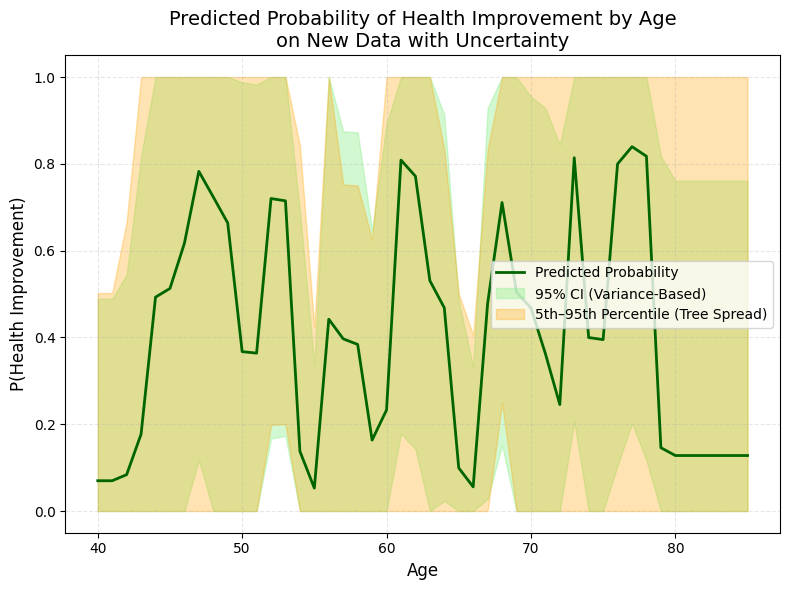

In [10]:
# Visualize: Probability of Health Improvement by Age (New Data)

plt.figure(figsize=(8, 6))

plt.plot(new_predictions['age'], new_predictions['predicted_probability'],
         color='darkgreen', linewidth=2, label='Predicted Probability')

plt.fill_between(new_predictions['age'],
                 new_predictions['lower_ci'],
                 new_predictions['upper_ci'],
                 color='lightgreen', alpha=0.4, label='95% CI (Variance-Based)')

# Optional: Add tree-based 5%-95% quantiles
if 'prob_5th' in new_predictions.columns:
    plt.fill_between(new_predictions['age'],
                     new_predictions['prob_5th'],
                     new_predictions['prob_95th'],
                     color='orange', alpha=0.3, label='5th–95th Percentile (Tree Spread)')

plt.xlabel('Age', fontsize=12)
plt.ylabel('P(Health Improvement)', fontsize=12)
plt.title('Predicted Probability of Health Improvement by Age\non New Data with Uncertainty', fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Summary and Conclusion

Probability Forests are a powerful tool for estimating conditional probabilities in classification tasks. They extend the random forest framework to provide probabilistic outputs, making them suitable for applications requiring uncertainty quantification. By averaging predictions across multiple trees, they offer robust and flexible estimates that can handle complex relationships between covariates and outcomes. This tutorial demonstrated how to implement a Probability Forest in Python, showcasing its ability to predict the probability of health improvement based on patient characteristics.
  


## References

1. [Probabilty Forest](https://grf-labs.github.io/grf/reference/probability_forest.html)